In [1]:
!pip install weaklabels

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.datasets import make_blobs

plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (10, 10)

plt.rcParams['image.cmap'] = 'tab20'

np.random.seed(42)

from matplotlib.lines import Line2D

# Colors used for up to 20 classes

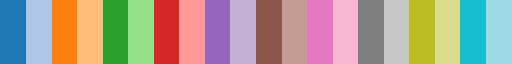

In [3]:
# All class colors from left to right
cmap = cm.get_cmap('tab20')
cmap

In [4]:
legend_multilabel = [Line2D([0],[0], marker='o', color=cmap(c), 
                            linewidth=0, markersize=10, label='Class {}'.format(c)) for c in range(20)]

## Evaluation measures

In [5]:
from sklearn.metrics import (accuracy_score, hamming_loss, precision_score,
                            recall_score, f1_score, roc_auc_score,
                            label_ranking_average_precision_score)

def mabs(y, q):
    return np.mean(np.abs(y - q))

def mse(y, q):
    return np.mean((y - q)**2)

def precision_micro(*args, **kwargs):
    return precision_score(*args, average='micro', **kwargs)

def precision_macro(*args, **kwargs):
    return precision_score(*args, average='macro', **kwargs)

def f1_micro(*args, **kwargs):
    return f1_score(*args, average='micro', **kwargs)

def f1_macro(*args, **kwargs):
    return f1_score(*args, average='macro', **kwargs)

def recall_micro(*args, **kwargs):
    return recall_score(*args, average='micro', **kwargs)

def recall_macro(*args, **kwargs):
    return recall_score(*args, average='macro', **kwargs)

#def precision_sample(*args, **kwargs):
#   return precision_score(*args, average='samples', **kwargs)

metrics_discrete = {'accuracy score': accuracy_score,
                    'hamming loss':hamming_loss,
                    'precision micro score': precision_micro,
                    'precision macro score': precision_macro,
                    'recall micro score': recall_micro,
                    'recall macro score': recall_macro,
                    'f1 micro score': f1_micro,
                    'f1 macro score': f1_macro}

metrics_continuous = {'roc auc': roc_auc_score,
                      'ranking average precision': label_ranking_average_precision_score}

# Generate a dataset

Synthetic dataset with a number of Gaussians

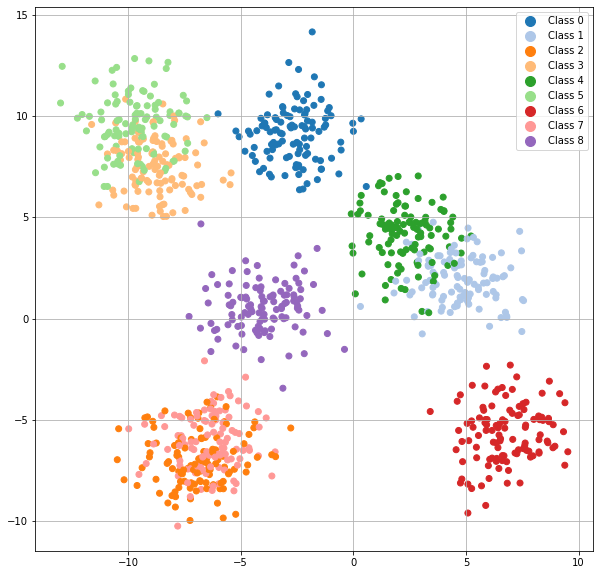

In [6]:
n_classes = 9
cluster_std = 12/n_classes

np.random.seed(42)
X, y = make_blobs(n_samples=1000, n_features=2, centers=n_classes,
                 cluster_std=cluster_std)

from sklearn.preprocessing import label_binarize
Y = label_binarize(y, classes=range(n_classes))

prior = [np.mean(y==i) for i in range(n_classes)]

plt.scatter(X[:,0], X[:,1], c=y, vmin=0, vmax=20)
plt.legend(handles=legend_multilabel[:n_classes])

# Estimate densities

Find the mean and covariance of each Gaussian and save the pdf estimators

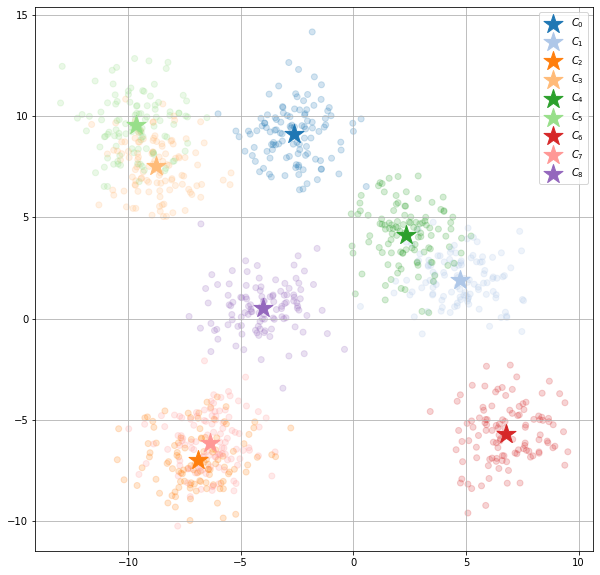

In [7]:
from scipy.stats import multivariate_normal

density_estimator_list = []
for i in range(n_classes):
    mean = X[y==i].mean(axis=0)
    cov = np.cov(X[y==i].T)
    density_estimator_list.append(multivariate_normal(mean=mean, cov=cov))
    plt.scatter(mean[0], mean[1], color=cmap(i), marker='*', s=400, label='$C_{}$'.format(i), zorder=10,
                vmin=0, vmax=20)

plt.legend()
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.2, vmin=0, vmax=20, cmap=cmap)

## Estimated densities per class

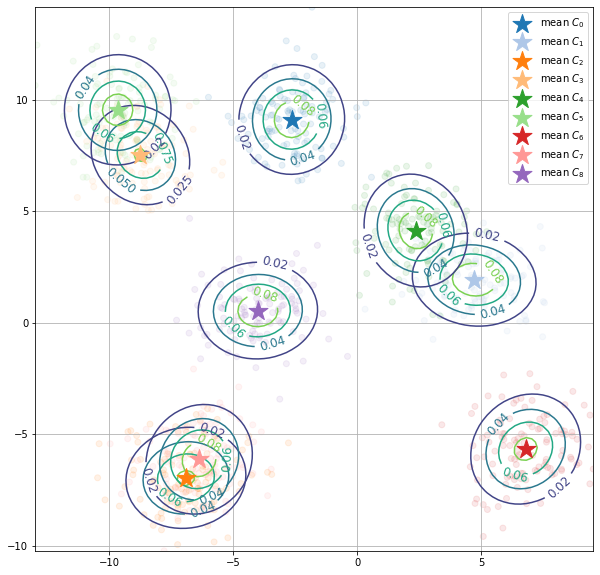

In [8]:
xlim = (X[:,0].min(), X[:,0].max())
ylim = (X[:,1].min(), X[:,1].max())

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 101),
                     np.linspace(ylim[0], ylim[1], 101))
for i in range(n_classes):
    scores = density_estimator_list[i].pdf(
        np.vstack([xx.flatten(), yy.flatten()]).T).reshape(101, 101)
    cs = plt.contour(xx, yy, scores, 4, cmap='viridis')
    plt.clabel(cs, inline=True, fontsize=12)
    plt.scatter(density_estimator_list[i].mean[0], density_estimator_list[i].mean[1],
                marker='*', s=400, label='mean $C_{}$'.format(i), 
                c=i, cmap=cmap, vmin=0, vmax=20, zorder=10)
plt.legend()
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.1, vmin=0, vmax=20)

## Score distribution per estimator

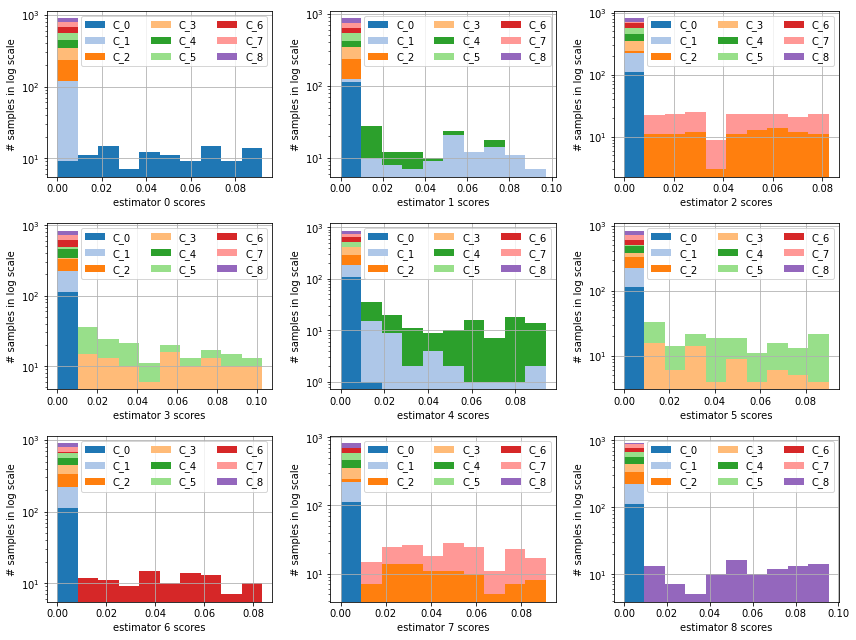

In [9]:
scores = []
columns = int(np.ceil(np.sqrt(n_classes)))
rows = int(np.ceil(n_classes/columns))
fig = plt.figure(figsize=(4*columns, 3*rows))
for i in range(n_classes):
    ax = fig.add_subplot(rows, columns, i+1)
    scores.append(density_estimator_list[i].pdf(X))
    ax.hist([scores[i][y==c] for c in range(n_classes)],
             bins=10, stacked=True,
             label=['C_{}'.format(c) for c in range(n_classes)],
             color=[cmap(c) for c in range(n_classes)])
    ax.set_yscale('log')
    ax.set_ylabel('# samples in log scale')
    ax.set_xlabel('estimator {} scores'.format(i))
    ax.legend(ncol=columns)
plt.tight_layout()
scores = np.array(scores).T

## Estimated densities

Example of the density values estimated for each sample and model

<ipython-input-10-7b73cc46d2a8>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(rows, columns, i+1)


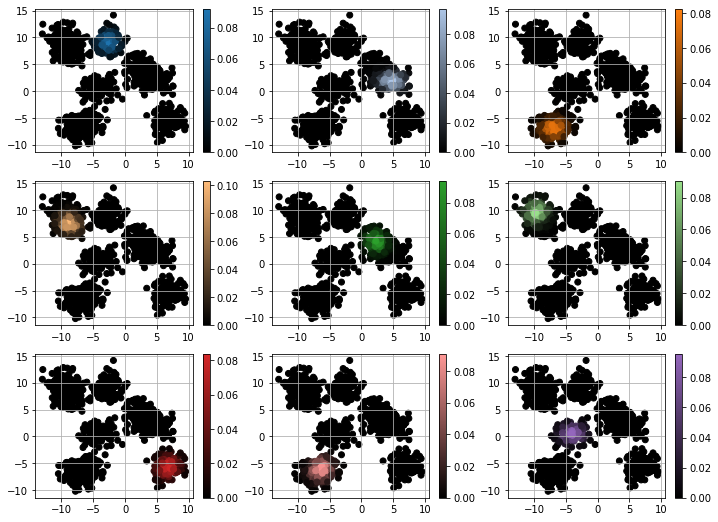

In [10]:
from matplotlib.colors import LinearSegmentedColormap


columns = np.ceil(np.sqrt(n_classes))
rows = np.ceil(n_classes/columns)
fig = plt.figure(figsize=(4*columns, 3*rows))
for i in range(n_classes):
    ax = fig.add_subplot(rows, columns, i+1)
    aux_cmap = LinearSegmentedColormap.from_list(
            'aux',
            [(0, 0, 0), cmap(i)])

    plt.scatter(X[:,0], X[:,1], c=density_estimator_list[i].pdf(X), cmap=aux_cmap)
    plt.colorbar()

# ROC curves


In [11]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
score = dict()
thresholds = dict()
for i in range(n_classes):
    score[i] = density_estimator_list[i].pdf(X)
    fpr[i], tpr[i], thresholds[i] = roc_curve(Y[:, i], score[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

Text(0, 0.5, 'TPR')

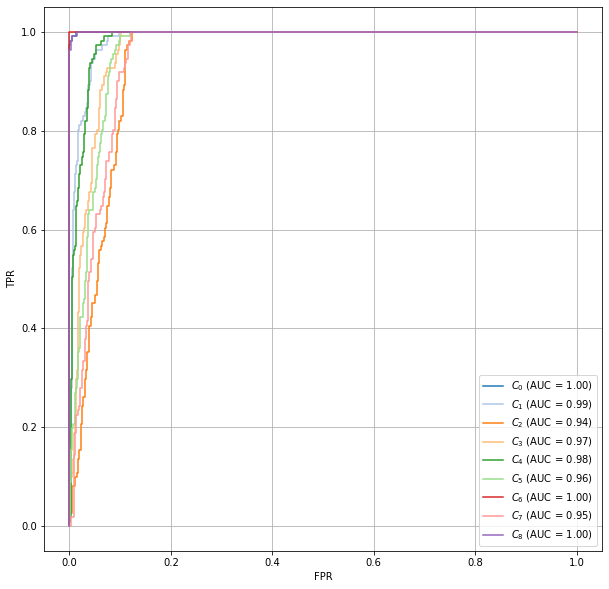

In [12]:
for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        color=cmap(i),
        label="$C_{0}$ (AUC = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')

# Density estimation evaluation

In [13]:
results_continuous = dict()
results_continuous_per_class = dict()
for name, f in metrics_continuous.items():
    results_continuous[name] = f(Y,scores)
    print('{} = {:.4f}'.format(name, results_continuous[name]))
    results_continuous_per_class[name] = []
    try:
        for i in range(n_classes):
            results_continuous_per_class[name].append(f(Y[:,i], scores[:,i]))
            print('  Class {} = {:.2f}'.format(i, results_continuous_per_class[name][i]))
    except ValueError as e:
        print(e)
        del results_continuous_per_class[name]

roc auc = 0.9774
  Class 0 = 1.00
  Class 1 = 0.99
  Class 2 = 0.94
  Class 3 = 0.97
  Class 4 = 0.98
  Class 5 = 0.96
  Class 6 = 1.00
  Class 7 = 0.95
  Class 8 = 1.00
ranking average precision = 0.9243
binary format is not supported


# Optimal threshold with iso-accuracy

$$
    \text{best-accuracy}_c = \arg\max_{\theta_c}P(Y_c) \text{TPR}_c(\theta_c) + P(Y_{\neg c})(1 - \text{FPR}_c(\theta_c))
$$


$$
\text{TNR}(\theta_c) = \frac{P(Y_c)}{P(Y_{\neg c})} \text{FNR}(\theta_c) 
                        + \frac{\text{best-accuracy}_c - P(Y_c)}{P(Y_{\neg c})}
$$

In [14]:
results = dict()
results_per_class = dict()

In [15]:
method = 'iso-accuracy'
results[method] = dict()
results_per_class[method] = dict()

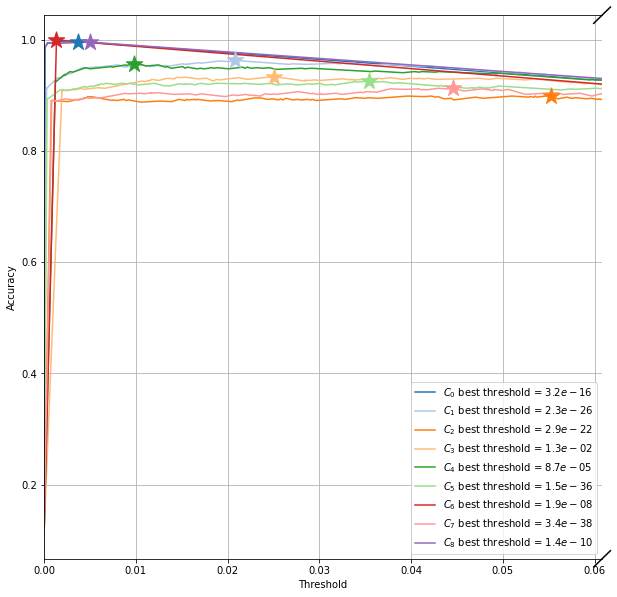

In [16]:
accuracies = dict()
best_threshold = dict()
best_ix = dict()
for i in range(n_classes):
    accuracies[i] = prior[i] * tpr[i] + (1-prior[i]) * (1 - fpr[i])
    best_ix[i] = np.argmax(accuracies[i])
    best_threshold[i] = score[i][best_ix[i]]
    plt.plot(thresholds[i], accuracies[i], c=cmap(i),
             label="$C_{0}$ best threshold = ${1:.1e}$".format(i, best_threshold[i]))
    plt.scatter(thresholds[i][best_ix[i]], accuracies[i][best_ix[i]], marker='*', s=300, zorder=10,
                c=i, vmin=0, vmax=20)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()

max_best_threshold = max([thresholds[i][best_ix[i]] for i in range(n_classes)])
plt.xlim([0, max_best_threshold*1.1])

ax = plt.gca()
ax.spines['right'].set_visible(False)
# Discontinuity on the right side of the ROC curve
# source: https://stackoverflow.com/questions/5656798/is-there-a-way-to-make-a-discontinuous-axis-in-matplotlib
d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
ax.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal

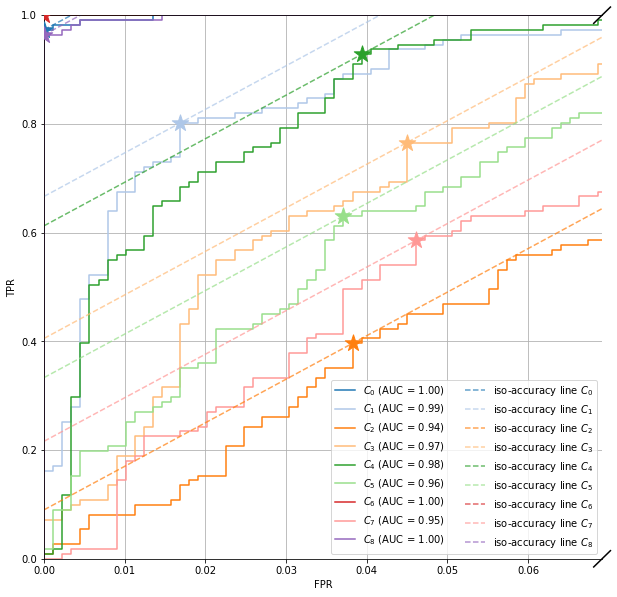

In [17]:
for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        label="$C_{0}$ (AUC = {1:0.2f})".format(i, roc_auc[i]),
        c=cmap(i)
    )
    plt.scatter(fpr[i][best_ix[i]], tpr[i][best_ix[i]], marker='*', s=300, zorder=10,
                c=i, vmin=0, vmax=20)
    
plt.xlabel('FPR')
plt.ylabel('TPR')

ax = plt.gca()
ax.spines['right'].set_visible(False)

max_best_fpr = max([fpr[i][best_ix[i]] for i in range(n_classes)])
plt.xlim([0, max_best_fpr*1.5])
# Discontinuity on the right side of the ROC curve
# source: https://stackoverflow.com/questions/5656798/is-there-a-way-to-make-a-discontinuous-axis-in-matplotlib
d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
ax.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal

isolines = np.linspace(0, 1, 2)
for i in range(n_classes):
    plt.plot(isolines, ((1 - prior[i])/(prior[i]))*isolines
                    + (accuracies[i][best_ix[i]] - (1 - prior[i]))/prior[i],
             '--', c=cmap(i), alpha=0.7, label='iso-accuracy line $C_{}$'.format(i))
plt.ylim(0, 1)

plt.legend(ncol=2)

In [18]:
Q = []
for i in range(n_classes):
    Q.append(scores[:,i] > best_threshold[i])
Q = np.array(Q).T

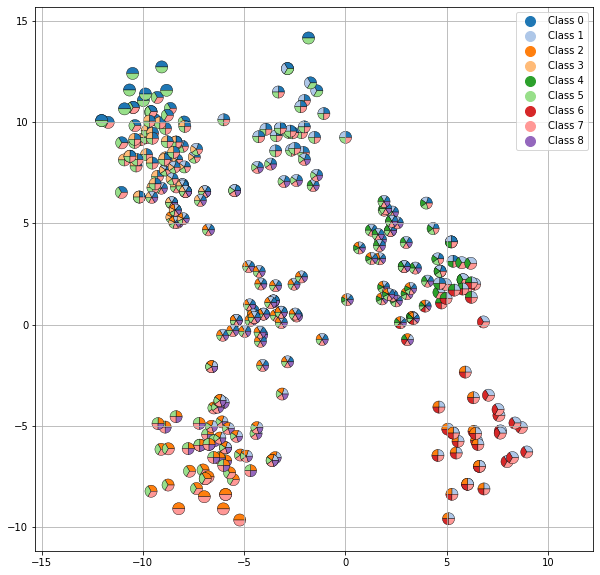

In [19]:
from weaklabels.WLvisualizer import plot_multilabel_scatter

subsample_idx = np.random.choice(X.shape[0], size=300)
fig = plt.figure()
plot_multilabel_scatter(X[subsample_idx], Q[subsample_idx], radius_scaler=70,
                        fig=fig);
plt.legend(handles=legend_multilabel[:n_classes])

<ipython-input-20-5c6e8a5f7866>:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(rows, columns, i+1)


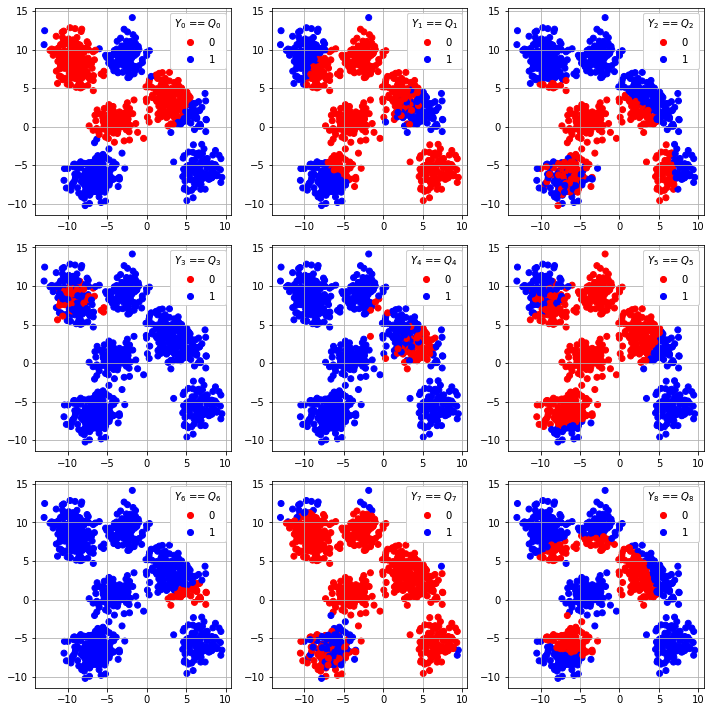

In [20]:
columns = np.ceil(np.sqrt(n_classes))
rows = np.ceil(n_classes/columns)
fig = plt.figure()
for i in range(n_classes):
    ax = fig.add_subplot(rows, columns, i+1)
    scatter = ax.scatter(X[:, 0], X[:, 1], 
                           c=(Y[:,i] == Q[:, i]),
                         cmap='bwr_r')
    legend1 = ax.legend(*scatter.legend_elements(), title="$Y_{}$ == $Q_{}$".format(i,i))
    ax.add_artist(legend1)

plt.tight_layout()

In [21]:
for name, f in metrics_discrete.items():
    results[method][name] = f(Y,Q)
    print('{} = {:.2f}'.format(name, results[method][name]))
    results_per_class[method][name] = []
    string_per_class = []
    for i in range(n_classes):
        results_per_class[method][name].append(f(Y[:,i], Q[:,i]))
        string_per_class.append('{:.2f}'.format(results_per_class[method][name][i]))
    print('    (' + ', '.join(string_per_class) + ')')

accuracy score = 0.00
    (0.51, 0.43, 0.65, 0.93, 0.90, 0.32, 0.95, 0.14, 0.68)
hamming loss = 0.39
    (0.49, 0.57, 0.35, 0.07, 0.10, 0.68, 0.05, 0.86, 0.33)
precision micro score = 0.22
    (0.51, 0.43, 0.65, 0.93, 0.90, 0.32, 0.95, 0.14, 0.68)
precision macro score = 0.33
    (0.59, 0.58, 0.62, 0.81, 0.76, 0.57, 0.85, 0.56, 0.63)
recall micro score = 0.99
    (0.51, 0.43, 0.65, 0.93, 0.90, 0.32, 0.95, 0.14, 0.68)
recall macro score = 0.99
    (0.72, 0.68, 0.80, 0.91, 0.94, 0.62, 0.97, 0.51, 0.82)
f1 micro score = 0.36
    (0.51, 0.43, 0.65, 0.93, 0.90, 0.32, 0.95, 0.14, 0.68)
f1 macro score = 0.45
    (0.46, 0.40, 0.57, 0.85, 0.81, 0.32, 0.90, 0.13, 0.59)


# Optimal threshold for imbalanced data

The geometric mean of the sensitivity and the specificity

$$
G-Mean = \sqrt{Sensitivity * Specificity} = \sqrt{TPR * (1 - FPR)}
$$

Check [A gentle introduction to threshold-moving for imbalanced classification](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification)

In [22]:
method = 'sens. * spec.'
results[method] = dict()
results_per_class[method] = dict()

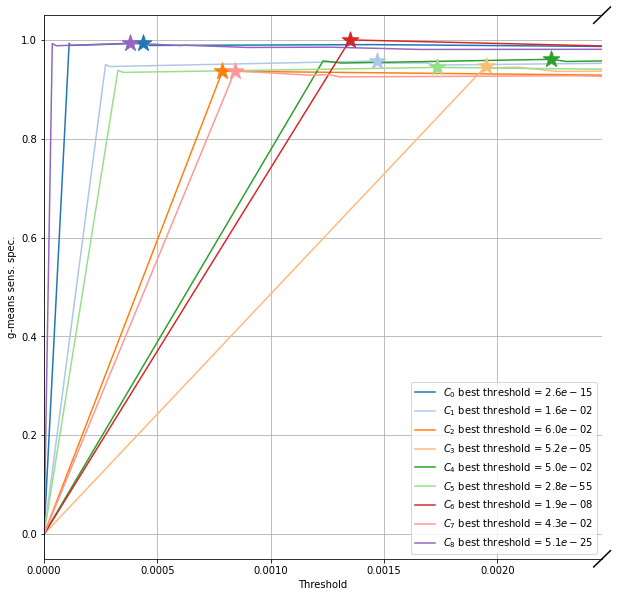

In [23]:
gmeans = dict()
best_threshold = dict()
best_ix = dict()
for i in range(n_classes):
    gmeans[i] = np.sqrt(tpr[i] * (1 - fpr[i]))
    best_ix[i] = np.argmax(gmeans[i])
    best_threshold[i] = score[i][best_ix[i]]
    plt.plot(thresholds[i], gmeans[i], c=cmap(i),
             label="$C_{0}$ best threshold = ${1:.1e}$".format(i, best_threshold[i]))
    plt.scatter(thresholds[i][best_ix[i]], gmeans[i][best_ix[i]], marker='*', s=300, zorder=10,
                c=i, vmin=0, vmax=20)
plt.xlabel('Threshold')
plt.ylabel('g-means sens. spec.')
plt.legend()

ax = plt.gca()
ax.spines['right'].set_visible(False)

max_best_threshold = max([thresholds[i][best_ix[i]] for i in range(n_classes)])
plt.xlim([0, max_best_threshold*1.1])
# Discontinuity on the right side of the ROC curve
# source: https://stackoverflow.com/questions/5656798/is-there-a-way-to-make-a-discontinuous-axis-in-matplotlib
d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
ax.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal

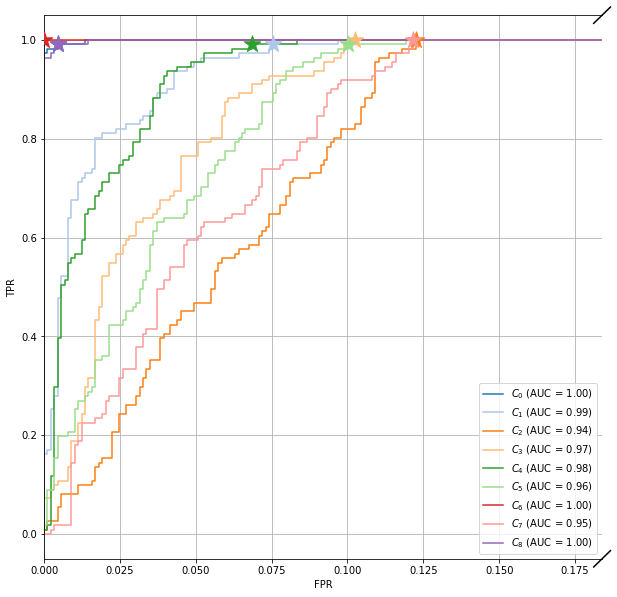

In [24]:
for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        label="$C_{0}$ (AUC = {1:0.2f})".format(i, roc_auc[i]),
        c=cmap(i)
    )
    plt.scatter(fpr[i][best_ix[i]], tpr[i][best_ix[i]], marker='*', s=300, zorder=10,
                c=i, vmin=0, vmax=20)
    
ax = plt.gca()
ax.spines['right'].set_visible(False)
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')


max_best_fpr = max([fpr[i][best_ix[i]] for i in range(n_classes)])
plt.xlim([0, max_best_fpr*1.5])
# Discontinuity on the right side of the ROC curve
# source: https://stackoverflow.com/questions/5656798/is-there-a-way-to-make-a-discontinuous-axis-in-matplotlib
d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
ax.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal

In [25]:
Q = []
for i in range(n_classes):
    Q.append(scores[:,i] > best_threshold[i])
Q = np.array(Q).T

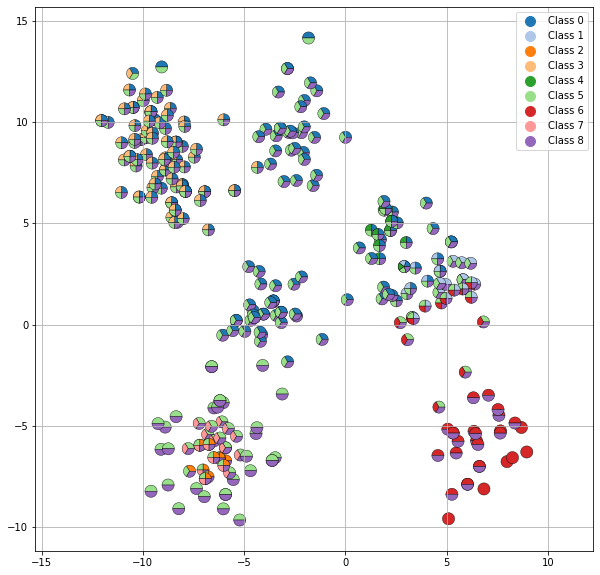

In [26]:
from weaklabels.WLvisualizer import plot_multilabel_scatter

fig = plt.figure()
plot_multilabel_scatter(X[subsample_idx], Q[subsample_idx], radius_scaler=70,
                        fig=fig);
plt.legend(handles=legend_multilabel[:n_classes])

<ipython-input-27-5c6e8a5f7866>:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(rows, columns, i+1)


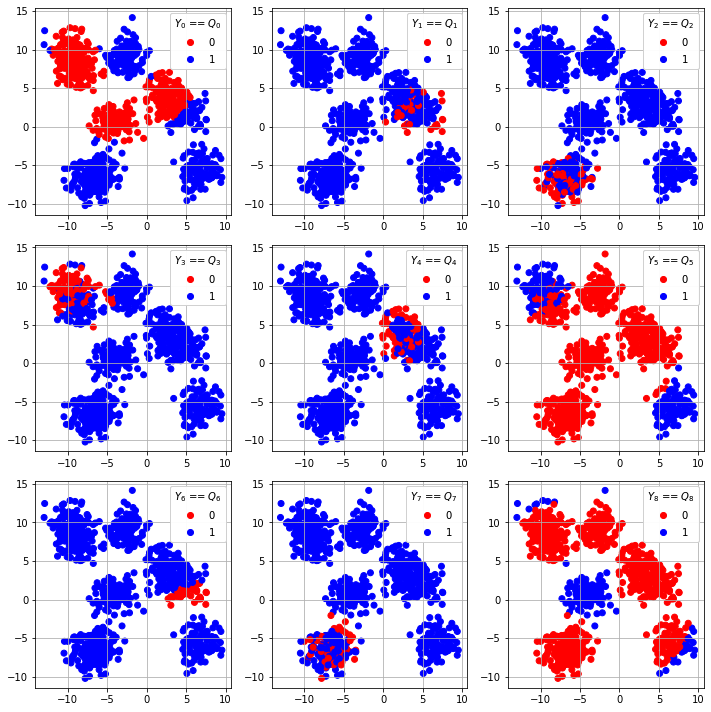

In [27]:
columns = np.ceil(np.sqrt(n_classes))
rows = np.ceil(n_classes/columns)
fig = plt.figure()
for i in range(n_classes):
    ax = fig.add_subplot(rows, columns, i+1)
    scatter = ax.scatter(X[:, 0], X[:, 1], 
                           c=(Y[:,i] == Q[:, i]),
                         cmap='bwr_r')
    legend1 = ax.legend(*scatter.legend_elements(), title="$Y_{}$ == $Q_{}$".format(i,i))
    ax.add_artist(legend1)

plt.tight_layout()

In [28]:
for name, f in metrics_discrete.items():
    results[method][name] = f(Y,Q)
    print('{} = {:.2f}'.format(name, results[method][name]))
    results_per_class[method][name] = []
    string_per_class = []
    for i in range(n_classes):
        results_per_class[method][name].append(f(Y[:,i], Q[:,i]))
        string_per_class.append('{:.2f}'.format(results_per_class[method][name][i]))
    print('    (' + ', '.join(string_per_class) + ')')

accuracy score = 0.03
    (0.52, 0.96, 0.89, 0.89, 0.94, 0.22, 0.95, 0.91, 0.14)
hamming loss = 0.29
    (0.48, 0.04, 0.11, 0.11, 0.06, 0.78, 0.05, 0.09, 0.85)
precision micro score = 0.25
    (0.52, 0.96, 0.89, 0.89, 0.94, 0.22, 0.95, 0.91, 0.14)
precision macro score = 0.50
    (0.59, 0.89, 0.72, 0.75, 0.93, 0.56, 0.85, 0.78, 0.56)
recall micro score = 0.80
    (0.52, 0.96, 0.89, 0.89, 0.94, 0.22, 0.95, 0.91, 0.14)
recall macro score = 0.80
    (0.73, 0.90, 0.63, 0.94, 0.74, 0.56, 0.97, 0.77, 0.52)
f1 micro score = 0.38
    (0.52, 0.96, 0.89, 0.89, 0.94, 0.22, 0.95, 0.91, 0.14)
f1 macro score = 0.52
    (0.47, 0.89, 0.66, 0.80, 0.80, 0.22, 0.90, 0.77, 0.14)


In [31]:
for name, f in metrics_continuous.items():
    probs = scores/scores.sum(axis=1)[:,None]
    results[method][name] = f(Y,probs)
    print('{} = {:.4f}'.format(name, results[method][name]))
    results_per_class[method][name] = []
    try:
        for i in range(n_classes):
            results_per_class[method][name].append(f(Y[:,i], probs[:,i]))
            print('  Class {} = {:.2f}'.format(i, results_per_class[method][name][i]))
    except ValueError as e:
        print(e)
        del results_per_class[method][name]

roc auc = 0.9867
  Class 0 = 1.00
  Class 1 = 0.99
  Class 2 = 0.96
  Class 3 = 0.98
  Class 4 = 0.99
  Class 5 = 0.98
  Class 6 = 1.00
  Class 7 = 0.96
  Class 8 = 1.00
ranking average precision = 0.9243
binary format is not supported


# 100% recall

Threshold to recall all the samples from the class

In [32]:
method = '100%-recall'
results[method] = dict()
results_per_class[method] = dict()

In [33]:
best_threshold = dict()
best_ix = dict()
for i in range(n_classes):
    best_threshold[i] = score[i][y==i].min()

In [34]:
Q = []
for i in range(n_classes):
    Q.append(scores[:,i] > best_threshold[i])
Q = np.array(Q).T

Do not belong to any class
Do not belong to any class


/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/weaklabels/WLvisualizer.py:51: RuntimeWarning: invalid value encountered in true_divide
  theta2s = np.cumsum(np.true_divide(y, y.sum())*360.0)


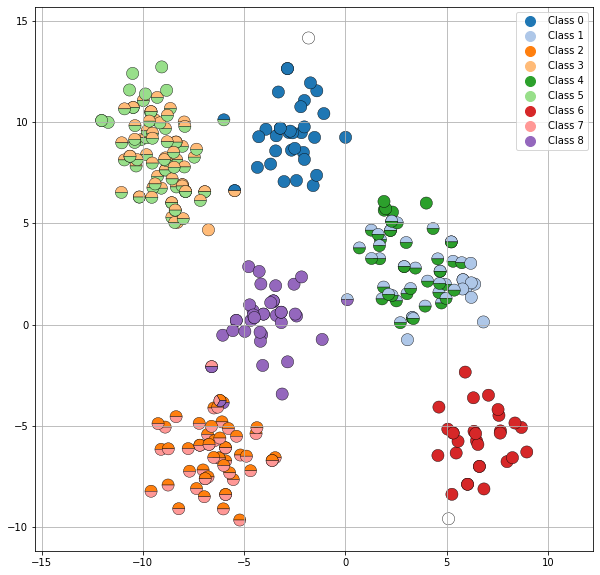

In [35]:
from weaklabels.WLvisualizer import plot_multilabel_scatter

fig = plt.figure()
plot_multilabel_scatter(X[subsample_idx], Q[subsample_idx], radius_scaler=70,
                        fig=fig);
plt.legend(handles=legend_multilabel[:n_classes])

<ipython-input-36-5c6e8a5f7866>:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(rows, columns, i+1)


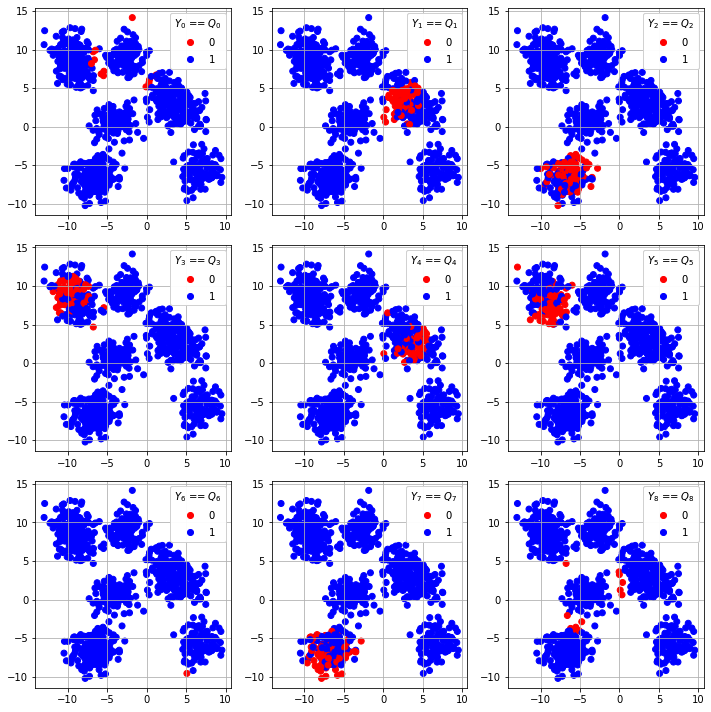

In [36]:
columns = np.ceil(np.sqrt(n_classes))
rows = np.ceil(n_classes/columns)
fig = plt.figure()
for i in range(n_classes):
    ax = fig.add_subplot(rows, columns, i+1)
    scatter = ax.scatter(X[:, 0], X[:, 1], 
                           c=(Y[:,i] == Q[:, i]),
                         cmap='bwr_r')
    legend1 = ax.legend(*scatter.legend_elements(), title="$Y_{}$ == $Q_{}$".format(i,i))
    ax.add_artist(legend1)

plt.tight_layout()

In [37]:
for name, f in metrics_discrete.items():
    results[method][name] = f(Y,Q)
    print('{} = {:.2f}'.format(name, results[method][name]))
    results_per_class[method][name] = []
    string_per_class = []
    for i in range(n_classes):
        results_per_class[method][name].append(f(Y[:,i], Q[:,i]))
        string_per_class.append('{:.2f}'.format(results_per_class[method][name][i]))
    print('    (' + ', '.join(string_per_class) + ')')

accuracy score = 0.41
    (0.99, 0.91, 0.89, 0.91, 0.93, 0.89, 1.00, 0.89, 0.99)
hamming loss = 0.07
    (0.01, 0.09, 0.11, 0.09, 0.07, 0.11, 0.00, 0.11, 0.01)
precision micro score = 0.62
    (0.99, 0.91, 0.89, 0.91, 0.93, 0.89, 1.00, 0.89, 0.99)
precision macro score = 0.67
    (0.95, 0.78, 0.75, 0.77, 0.80, 0.75, 1.00, 0.75, 0.95)
recall micro score = 0.99
    (0.99, 0.91, 0.89, 0.91, 0.93, 0.89, 1.00, 0.89, 0.99)
recall macro score = 0.99
    (0.99, 0.95, 0.93, 0.94, 0.95, 0.94, 1.00, 0.93, 0.99)
f1 micro score = 0.77
    (0.99, 0.91, 0.89, 0.91, 0.93, 0.89, 1.00, 0.89, 0.99)
f1 macro score = 0.78
    (0.97, 0.83, 0.80, 0.83, 0.85, 0.80, 1.00, 0.80, 0.97)


In [42]:
for name, f in metrics_continuous.items():
    probs = scores/scores.sum(axis=1)[:,None]
    results[method][name] = f(Y,probs)
    print('{} = {:.4f}'.format(name, results[method][name]))
    results_per_class[method][name] = []
    try:
        for i in range(n_classes):
            results_per_class[method][name].append(f(Y[:,i], probs[:,i]))
            print('  Class {} = {:.2f}'.format(i, results_per_class[method][name][i]))
    except ValueError as e:
        print(e)
        del results_per_class[method][name]

roc auc = 0.9867
  Class 0 = 1.00
  Class 1 = 0.99
  Class 2 = 0.96
  Class 3 = 0.98
  Class 4 = 0.99
  Class 5 = 0.98
  Class 6 = 1.00
  Class 7 = 0.96
  Class 8 = 1.00
ranking average precision = 0.9243
binary format is not supported


# 95% recall

Threshold to recall all 95% of the samples from the class

In [43]:
method = '95%-recall'
results[method] = dict()
results_per_class[method] = dict()

In [44]:
best_threshold = dict()
best_ix = dict()
for i in range(n_classes):
    sorted_scores = -np.sort(-score[i][y==i])
    percentile_pos = int(np.ceil(len(sorted_scores)*0.95))
    best_threshold[i] = sorted_scores[percentile_pos]

In [45]:
Q = []
for i in range(n_classes):
    Q.append(scores[:,i] > best_threshold[i])
Q = np.array(Q).T

Do not belong to any class
Do not belong to any class
Do not belong to any class
Do not belong to any class


/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/weaklabels/WLvisualizer.py:51: RuntimeWarning: invalid value encountered in true_divide
  theta2s = np.cumsum(np.true_divide(y, y.sum())*360.0)


Do not belong to any class
Do not belong to any class
Do not belong to any class
Do not belong to any class
Do not belong to any class
Do not belong to any class
Do not belong to any class
Do not belong to any class
Do not belong to any class
Do not belong to any class


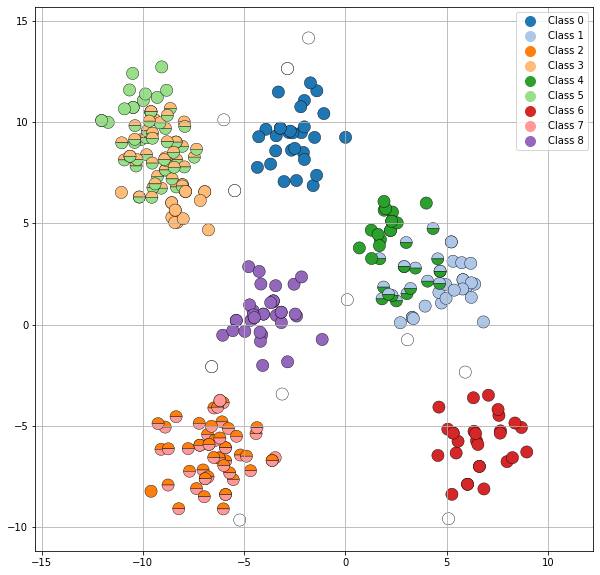

In [46]:
from weaklabels.WLvisualizer import plot_multilabel_scatter

fig = plt.figure()
plot_multilabel_scatter(X[subsample_idx], Q[subsample_idx], radius_scaler=70,
                        fig=fig);
plt.legend(handles=legend_multilabel[:n_classes])

<ipython-input-47-5c6e8a5f7866>:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(rows, columns, i+1)


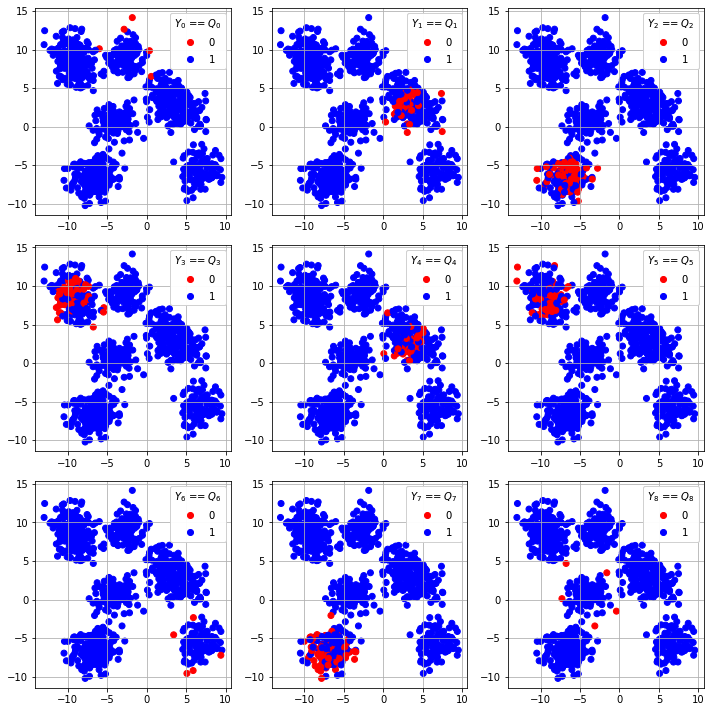

In [47]:
columns = np.ceil(np.sqrt(n_classes))
rows = np.ceil(n_classes/columns)
fig = plt.figure()
for i in range(n_classes):
    ax = fig.add_subplot(rows, columns, i+1)
    scatter = ax.scatter(X[:, 0], X[:, 1], 
                           c=(Y[:,i] == Q[:, i]),
                         cmap='bwr_r')
    legend1 = ax.legend(*scatter.legend_elements(), title="$Y_{}$ == $Q_{}$".format(i,i))
    ax.add_artist(legend1)

plt.tight_layout()

In [48]:
for name, f in metrics_discrete.items():
    results[method][name] = f(Y,Q)
    print('{} = {:.2f}'.format(name, results[method][name]))
    results_per_class[method][name] = []
    string_per_class = []
    for i in range(n_classes):
        results_per_class[method][name].append(f(Y[:,i], Q[:,i]))
        string_per_class.append('{:.2f}'.format(results_per_class[method][name][i]))
    print('    (' + ', '.join(string_per_class) + ')')

accuracy score = 0.51
    (0.99, 0.95, 0.90, 0.91, 0.95, 0.92, 0.99, 0.89, 0.99)
hamming loss = 0.06
    (0.01, 0.05, 0.10, 0.09, 0.05, 0.08, 0.01, 0.11, 0.01)
precision micro score = 0.68
    (0.99, 0.95, 0.90, 0.91, 0.95, 0.92, 0.99, 0.89, 0.99)
precision macro score = 0.73
    (1.00, 0.85, 0.76, 0.77, 0.84, 0.78, 1.00, 0.75, 1.00)
recall micro score = 0.95
    (0.99, 0.95, 0.90, 0.91, 0.95, 0.92, 0.99, 0.89, 0.99)
recall macro score = 0.95
    (0.98, 0.95, 0.92, 0.93, 0.95, 0.93, 0.98, 0.92, 0.98)
f1 micro score = 0.79
    (0.99, 0.95, 0.90, 0.91, 0.95, 0.92, 0.99, 0.89, 0.99)
f1 macro score = 0.81
    (0.99, 0.89, 0.81, 0.82, 0.89, 0.83, 0.99, 0.80, 0.99)


In [49]:
for name, f in metrics_continuous.items():
    probs = scores/scores.sum(axis=1)[:,None]
    results[method][name] = f(Y,probs)
    print('{} = {:.4f}'.format(name, results[method][name]))
    results_per_class[method][name] = []
    try:
        for i in range(n_classes):
            results_per_class[method][name].append(f(Y[:,i], probs[:,i]))
            print('  Class {} = {:.2f}'.format(i, results_per_class[method][name][i]))
    except ValueError as e:
        print(e)
        del results_per_class[method][name]

roc auc = 0.9867
  Class 0 = 1.00
  Class 1 = 0.99
  Class 2 = 0.96
  Class 3 = 0.98
  Class 4 = 0.99
  Class 5 = 0.98
  Class 6 = 1.00
  Class 7 = 0.96
  Class 8 = 1.00
ranking average precision = 0.9243
binary format is not supported


# Summary

<Figure size 720x720 with 0 Axes>

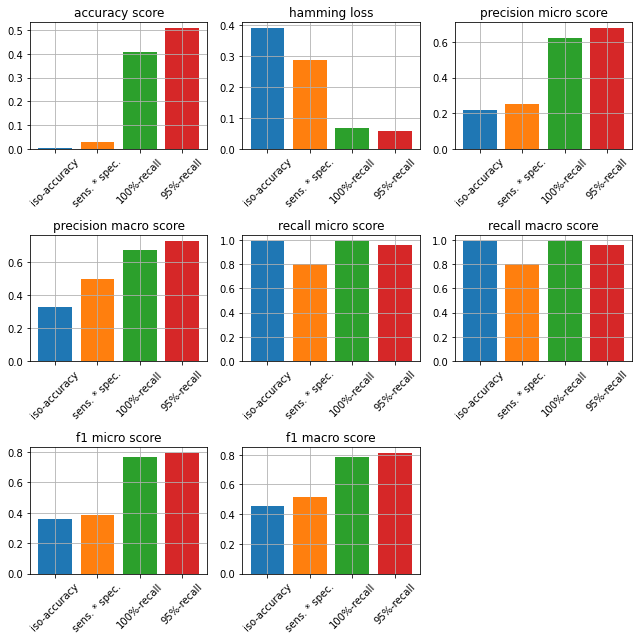

In [50]:
all_metrics = list(list(results.items())[0][1].keys())
n_metrics = len(all_metrics)

columns = int(np.ceil(np.sqrt(n_metrics)))
rows = int(np.ceil(n_metrics/columns))
fig = plt.figure()
    
fig = plt.figure(figsize=(3*columns, 3*rows))
for i, metric in enumerate(all_metrics):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title(metric)
    for method in results.keys():
        ax.bar(method, results[method][metric])
    plt.xticks(rotation = 45)
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

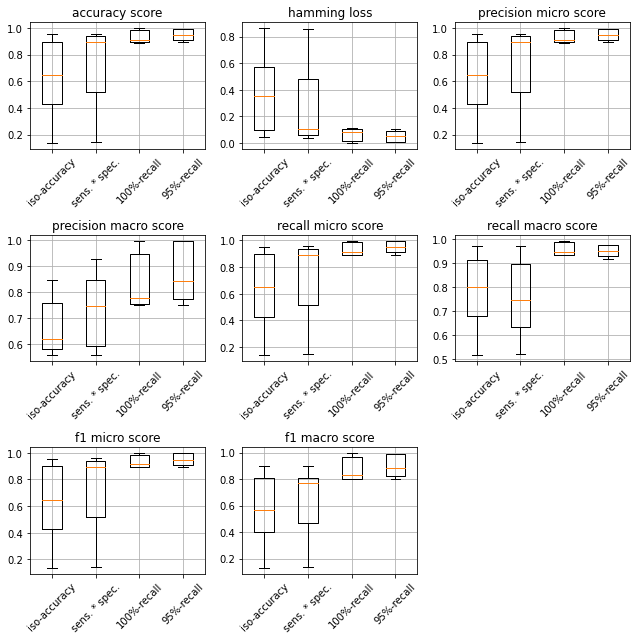

In [51]:
all_metrics = list(list(results_per_class.items())[0][1].keys())
n_metrics = len(all_metrics)

columns = int(np.ceil(np.sqrt(n_metrics)))
rows = int(np.ceil(n_metrics/columns))
fig = plt.figure()
    
fig = plt.figure(figsize=(3*columns, 3*rows))
for i, metric in enumerate(all_metrics):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title(metric)
    ax.boxplot([results_per_class[method][metric] for method in results_per_class.keys()], labels=results_per_class.keys())
    plt.xticks(rotation = 45)
plt.tight_layout()